### 0. model and weights load


아래의 링크에서 전처리가 완료된 데이터를 받아 풀어주세요.

- 전처리 데이터
  https://drive.google.com/file/d/1g1vj_2koQNjOR6u55kB5bpso4HD2WIm5/view?usp=sharing

- 학습된 모델
  https://drive.google.com/file/d/1h9QY23Ee3wEM_cW0f739Lh0pTKpYSLWl/view?usp=sharing


In [2]:
import sys

sys.path.append("..")

In [14]:
import albumentations as A
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
from PIL import Image
from pathlib import Path
from functools import reduce

#
from src.dataset import WallSectionDataset, splitDataset
from src.preproecess import RGB2IDX
from src.model import load_Mask2Former_model_from_huggingface
from src.preproecess import Preprocesser

In [4]:
PATH_CHECKPOINT = Path("../checkpoints/trained_weight.pt")

In [5]:
model = load_Mask2Former_model_from_huggingface(len(RGB2IDX))
model.load_state_dict(torch.load(PATH_CHECKPOINT, map_location=torch.device("cpu")))

Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-small-ade-semantic and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([16, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([16]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([16]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

### 1. Load dataset


In [6]:
from transformers import Mask2FormerImageProcessor
from torch.utils.data import DataLoader

In [7]:
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

train_transform = A.Compose(
    [
        A.RandomCrop(width=512, height=512),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=ADE_MEAN, std=ADE_STD),
    ]
)

test_transform = A.Compose(
    [
        A.Resize(width=512, height=512),
        A.Normalize(mean=ADE_MEAN, std=ADE_STD),
    ]
)

wall_dataset = WallSectionDataset(
    root_paths=["../data/raw/WD/", "../data/raw/cStud/", "../data/raw/cmu/", "../data/raw/tile/"],
    transform=train_transform,
)
#
train_dataset, test_dataset = splitDataset(wall_dataset)

In [8]:
# Create a preprocessor
preprocessor = Mask2FormerImageProcessor(
    ignore_index=0, reduce_labels=False, do_resize=False, do_rescale=False, do_normalize=False
)


#
def collate_fn(batch):
    inputs = list(zip(*batch))
    images = inputs[0]
    segmentation_maps = inputs[1]
    batch = preprocessor(
        images,
        segmentation_maps=segmentation_maps,
        return_tensors="pt",
    )
    batch["original_images"] = inputs[1]
    batch["original_segmentation_maps"] = inputs[1]
    return batch


#
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

#### 2. Verify


In [9]:
from src.utils import getSegmentationPathFromImagePath, showSegmentationMap, COLORS_MAP

In [10]:
#
train_image, train_segmap = train_dataset[0]
test_image, test_segmap = test_dataset[0]
#
with torch.no_grad():
    train_image_output = preprocessor.post_process_semantic_segmentation(
        model.forward(**preprocessor(train_image, return_tensors="pt"))
    )
    test_image_output = preprocessor.post_process_semantic_segmentation(
        model.forward(**preprocessor(test_image, return_tensors="pt"))
    )

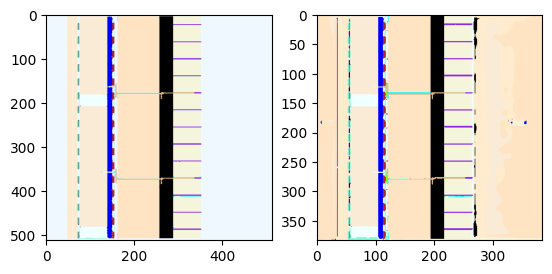

In [11]:
plt.subplot(1, 2, 1)
plt.imshow(showSegmentationMap(train_segmap, labels=RGB2IDX))
plt.subplot(1, 2, 2)
plt.imshow(showSegmentationMap(train_image_output[0].numpy(), labels=RGB2IDX))
plt.show()

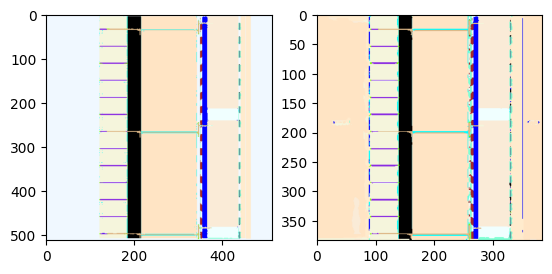

In [12]:
plt.subplot(1, 2, 1)
plt.imshow(showSegmentationMap(test_segmap, labels=RGB2IDX))
plt.subplot(1, 2, 2)
plt.imshow(showSegmentationMap(test_image_output[0].numpy(), labels=RGB2IDX))
plt.show()

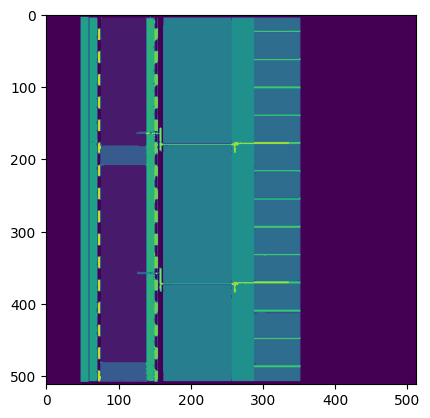

In [13]:
# --- test get graph from segmentation map
test_segmap = np.array(
    Image.open(getSegmentationPathFromImagePath(train_dataset._originl_image_path[0]))
)
plt.imshow(test_segmap)
# labels,labelMap = cv2.connectedComponents(test_segmap)

In [15]:
# Extract each class region and calculate center coordinates
class_centers = {}
class_indices = np.unique(test_segmap)
for class_index in class_indices:
    if class_index == 0:  # Skip background
        continue
    class_mask = np.where(test_segmap == class_index, 1, 0).astype(np.uint8)
    contours, _ = cv2.findContours(class_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    center_list = []
    for contour in contours:
        moments = cv2.moments(contour)
        if moments["m00"] == 0:
            continue
        center = (int(moments["m10"] / moments["m00"]), int(moments["m01"] / moments["m00"]))
        center_list.append(center)
    class_centers[class_index] = center_list
#
center = list(map(lambda x: [[x, *list(item)] for item in class_centers[x]], class_centers))
points = np.array(reduce(lambda x, y: x + y, center))

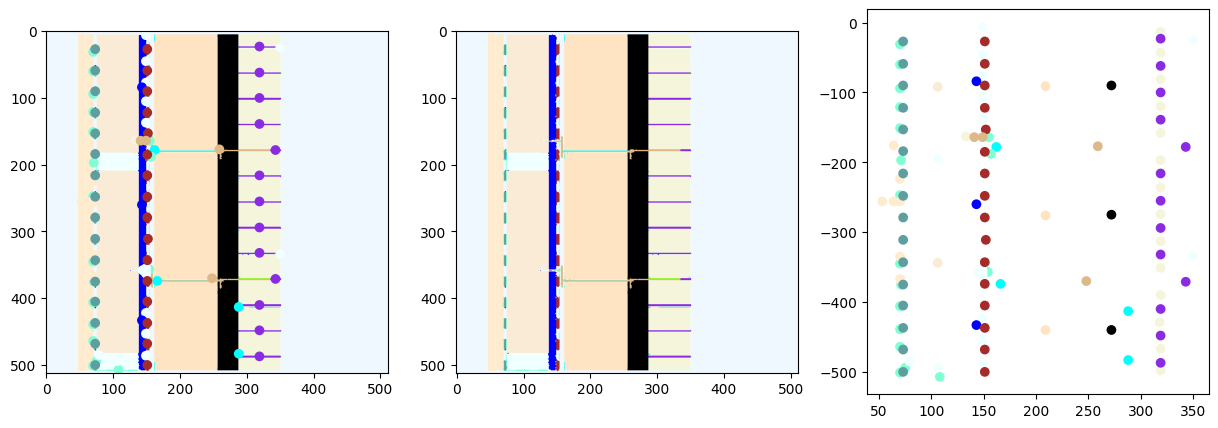

In [16]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(showSegmentationMap(test_segmap, labels=RGB2IDX))
#
plt.scatter(*points[:, 1:].T, c=COLORS_MAP[points[:, 0]] / 255)
plt.subplot(1, 3, 2)
plt.imshow(showSegmentationMap(test_segmap, labels=RGB2IDX))
#
plt.subplot(1, 3, 3)
plt.scatter(x=points[:, 1].T, y=-points[:, 2].T, c=COLORS_MAP[points[:, 0]] / 255)
plt.show()

### Make Graph


In [17]:
from src.makeGraph import make_graph
import networkx as nx

In [18]:
built_graph = make_graph(x=points[:, 1], y=points[:, 2], threshold=100)

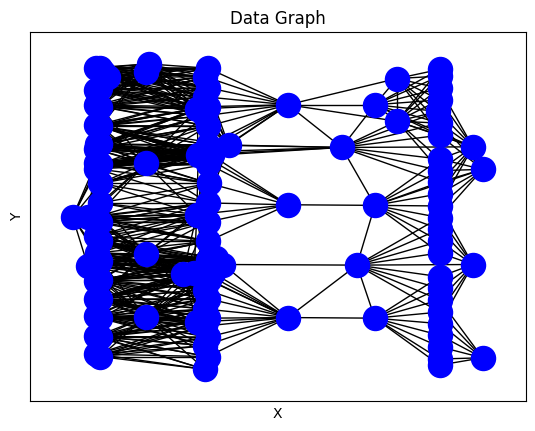

In [19]:
plt.figure()
plt.title("Data Graph")
plt.xlabel("X")
plt.ylabel("Y")
pos = {i: (points[i, 1], points[i, 2]) for i in range(len(points))}
nx.draw_networkx_nodes(built_graph, pos, node_color="b")
nx.draw_networkx_edges(built_graph, pos, edge_color="k")
plt.show()